In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import gc
from tqdm import tqdm
import time
from datetime import datetime
import datetime as dt
from sklearn.metrics import confusion_matrix,f1_score,precision_score,recall_score,roc_auc_score,roc_curve
from tensorflow.keras.callbacks import Callback
import random
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.metrics import precision_score, recall_score,f1_score
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, LSTM, Dropout,GRU,LeakyReLU, BatchNormalization
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
import tensorflow as tf

2022-03-05 21:50:57.542195: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
tqdm.pandas()

In [3]:
def seed_everything(seed=51):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [4]:
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

In [5]:
seed_everything(seed=51)

In [6]:
def timer_decorator(function_to_call):
    def wrapper(*args,**kwargs):
        time_before = datetime.now()
        value_to_return =  function_to_call(*args,**kwargs)
        time_after = datetime.now()
        print(f"data elapsed = {time_after - time_before}")
        return value_to_return
    return wrapper

In [7]:
@timer_decorator
def read_data(path):
    df = pd.read_csv(path)
    print("========")
    print(f"Shape of data = {df.shape}")
    print("========")
    print("Column types are:")
    print(df.dtypes)
    print("========")
    print("Take a glance at data")
    print(pd.concat([df.head(),df.tail()],axis=0))
    print("========")
    return df

In [8]:
data = read_data('15mindata.csv')

Shape of data = (350688, 2)
Column types are:
time     object
open    float64
dtype: object
Take a glance at data
                       time      open
0       2012-01-01 00:00:00      4.58
1       2012-01-01 00:15:00      4.58
2       2012-01-01 00:30:00      4.58
3       2012-01-01 00:45:00      4.58
4       2012-01-01 01:00:00      4.58
350683  2021-12-31 22:45:00  46290.58
350684  2021-12-31 23:00:00  46303.98
350685  2021-12-31 23:15:00  46429.65
350686  2021-12-31 23:30:00  46350.44
350687  2021-12-31 23:45:00  46465.54
data elapsed = 0:00:00.214483


In [9]:
def copy_data(df):
    return df.copy()

In [10]:
@timer_decorator
def create_date_columns(df):
    df['time'] = pd.to_datetime(df['time'])
    df['year'] = df['time'].dt.year
    df['month'] = df['time'].dt.month
    df['day'] = df['time'].dt.day
    df['hour'] = df['time'].dt.hour
    df['minute'] = df['time'].dt.minute
    return df

In [11]:
#data = create_date_columns(data)

In [12]:
@timer_decorator
def filter_data(df,drop_years, hour_to_keep, minute_to_keep):
    filter_ = (~df['year'].isin(drop_years)) & (df['hour'] % hour_to_keep == 0) & (df['minute'] == 0)
    return df[filter_]

In [13]:
#data = filter_data(data,[2012],4,0)

# Set Parameters

In [14]:
time_step = 120
next_period = 1
n_features = 1

In [15]:
@timer_decorator
def create_train_data(df,time_step,next_period):
    arr = np.array(df['open'])
    input_data = []
    target_data = []
    for i in tqdm(range(len(arr) - time_step)):
        input_data.append(arr[i:i+time_step])
        target_data.append(arr[i+time_step])
    input_data = np.asarray(input_data)
    target_data = np.asarray(target_data)
    mydata = pd.DataFrame(input_data,columns = ['T{}'.format(i) for i in range(1,time_step + 1,1)])
    mydata['target'] = target_data
    
    print(f"Training data size =  {mydata.shape}")
    
    return mydata

In [16]:
#data = create_train_data(data,time_step,next_period)

In [17]:
def label_maker(x):
    if x <= -1.5:
        return 0
    elif (-1.5 < x) & (x <= 1.5):
        return 1
    elif 1.5 < x :
        return 2
    else:
        pass

In [18]:
@timer_decorator
def create_label(df):
    df['scaled_target'] = (df.iloc[:,-1] - df.iloc[:,-2]) / df.iloc[:,-2]
    df['percentile_target'] = df['scaled_target']*100
    df['categorical_target_change'] = (df['percentile_target'].abs() > 1.25) *1
    return df

In [19]:
#data = create_label(data)

In [20]:
data.tail()

,time,open
350683,2021-12-31 22:45:00,46290.58
350684,2021-12-31 23:00:00,46303.98
350685,2021-12-31 23:15:00,46429.65
350686,2021-12-31 23:30:00,46350.44
350687,2021-12-31 23:45:00,46465.54


In [21]:
@timer_decorator
def create_columnwise_features(df,time_step):
    df['columnwise_min'] = df.iloc[:,:time_step].min(axis=1)
    df['columnwise_max'] = df.iloc[:,:time_step].max(axis=1)
    df['columnwise_median'] = df.iloc[:,:time_step].median(axis=1)
    return df

In [22]:
#data = create_columnwise_features(data,time_step)

In [23]:
def scale_btw_neg1_and_pos1(df,time_step):
    df[[f'T{x}' for x in range (1,time_step+1,1) ]] = \
    np.array([ np.interp( x, ( np.array(x).min(),np.array(x).max() ), (-1,1) )\
              for x in df[[f'T{x}' for x in range (1,time_step+1,1) ]].values.tolist() ])
    return df

In [24]:
def scale_btw_0_and_1(df,time_step):
    for i in range(1,time_step+1,1):
        df['T{}'.format(i)] = (df['T{}'.format(i)] - df['columnwise_min']) / (df['columnwise_max'] - df['columnwise_min'])
    return df

In [25]:
#data = scale_btw_0_and_1(data,time_step)

In [26]:
data.tail()

,time,open
350683,2021-12-31 22:45:00,46290.58
350684,2021-12-31 23:00:00,46303.98
350685,2021-12-31 23:15:00,46429.65
350686,2021-12-31 23:30:00,46350.44
350687,2021-12-31 23:45:00,46465.54


In [27]:
def create_input_via_shifting(df, time_step):
    print(df.shape)
    for i in range(1,time_step+1,1):
        df['T{}'.format(time_step + 1 - i)] = df['categorical_target_change'].shift(i)
    
    df = df[time_step:].reset_index(drop=True)
    print(df.shape)
    return df

In [28]:
#data = create_input_via_shifting(data, time_step)

In [29]:
data.tail()

,time,open
350683,2021-12-31 22:45:00,46290.58
350684,2021-12-31 23:00:00,46303.98
350685,2021-12-31 23:15:00,46429.65
350686,2021-12-31 23:30:00,46350.44
350687,2021-12-31 23:45:00,46465.54


In [30]:
#mydata['categorical_target'].value_counts(normalize=True)

In [31]:
data.head()

,time,open
0,2012-01-01 00:00:00,4.58
1,2012-01-01 00:15:00,4.58
2,2012-01-01 00:30:00,4.58
3,2012-01-01 00:45:00,4.58
4,2012-01-01 01:00:00,4.58


In [32]:
data = (data.pipe(copy_data)
     .pipe(create_date_columns)
     .pipe(filter_data,drop_years = [2012],hour_to_keep = 4,minute_to_keep = 0)
     .pipe(create_train_data,time_step,next_period)
     .pipe(create_label)
     .pipe(create_input_via_shifting,time_step)
)

data elapsed = 0:00:00.189527
data elapsed = 0:00:00.011883


100%|████████████████████████████████| 19602/19602 [00:00<00:00, 1518174.63it/s]

Training data size =  (19602, 121)
data elapsed = 0:00:00.030702
data elapsed = 0:00:00.002665
(19602, 124)
(19482, 124)


In [33]:
data.head()

,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,T12,T13,T14,T15,T16,T17,T18,T19,T20,T21,T22,T23,T24,T25,T26,T27,T28,T29,T30,T31,T32,T33,T34,T35,T36,T37,T38,T39,T40,T41,T42,T43,T44,T45,T46,T47,T48,T49,T50,T51,T52,T53,T54,T55,T56,T57,T58,T59,T60,T61,T62,T63,T64,T65,T66,T67,T68,T69,T70,T71,T72,T73,T74,T75,T76,T77,T78,T79,T80,T81,T82,T83,T84,T85,T86,T87,T88,T89,T90,T91,T92,T93,T94,T95,T96,T97,T98,T99,T100,T101,T102,T103,T104,T105,T106,T107,T108,T109,T110,T111,T112,T113,T114,T115,T116,T117,T118,T119,T120,target,scaled_target,percentile_target,categorical_target_change
0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,23.13,-0.005161,-0.516129,0
1,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,23.49,0.015564,1.556420,1
2,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,23.16,-0.014049,-1.404853,1
3,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,23.46,0.012953,1.295337,1
4,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,23.07,-0.016624,-1.662404,1


# Create Train, Test, Valid

In [34]:
data['categorical_target_change'].value_counts(normalize=True)

0    0.736526
1    0.263474
Name: categorical_target_change, dtype: float64

In [35]:
def create_train_valid_test(df,time_step,train_ratio=0.7,valid_ratio=0.15):
    train_border = train_ratio
    valid_border = train_border + valid_ratio
    
    X_train = df[['T{}'.format(t) for t in range(1,time_step +1,1) ]][:int(len(df)*train_border)].values
    X_val = df[['T{}'.format(t) for t in range(1,time_step + 1,1) ]][int(len(df)*train_border):int(len(df)*valid_border)].values
    X_test = df[['T{}'.format(t) for t in range(1,time_step + 1,1) ]][int(len(df)*valid_border):].values
    
    y_train = df['categorical_target_change'][:int(len(df)*train_border)]
    y_val = df['categorical_target_change'][int(len(df)*train_border):int(len(df)*valid_border)]
    y_test = df['categorical_target_change'][int(len(df)*valid_border):]
    
    print(f"Train size = {len(X_train)}; Valid size = {len(X_val)}; Test size = {len(X_test)}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test
    

In [36]:
X_train, X_val , X_test, y_train, y_val, y_test = create_train_valid_test(data, time_step)

Train size = 13637; Valid size = 2922; Test size = 2923


# Create weights of classes inproportional to percentages

In [37]:
def create_weights(series):
    print("Class Distributions are ")
    print(series.value_counts(normalize=True))
    weight_dict= {x[0]: 1/x[1]  for x in series.value_counts(normalize=True).to_dict().items()}
    return weight_dict

In [38]:
weight_dict = create_weights(y_train)

Class Distributions are 
0    0.739825
1    0.260175
Name: categorical_target_change, dtype: float64


# Oversampling data

In [39]:
from imblearn.over_sampling import SMOTE
def oversample_train(X,y):
    X,y = shuffle(X,y,random_state=60)
    smote = SMOTE(random_state=51)
    X,y = smote.fit_resample(X,y)
    print(X.shape,y.shape)
    return X,y

In [40]:
#X_train, y_train = oversample_train(X_train, y_train)

# Dummifacation of Target

In [41]:
def dummify_y_columns(training_y,valid_y,test_y):
    training_y = pd.get_dummies(training_y)
    valid_y = pd.get_dummies(valid_y)
    test_y = pd.get_dummies(test_y)
    print(f"Shapes after dummification in train, valid, test order = [{training_y.shape,valid_y.shape, test_y.shape}]")
    return training_y, valid_y, test_y

In [42]:
# y_train, y_val, y_test = dummify_y_columns(y_train, y_val, y_test)

# Resape Input for LSTM's

In [43]:
def reshape_input(training_X, valid_X, test_X, n_features):
    training_X = training_X.reshape((training_X.shape[0], training_X.shape[1], n_features))
    valid_X = valid_X.reshape((valid_X.shape[0], valid_X.shape[1], n_features))
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], n_features))
    print(f"Shapes after reshaping are in order [{training_X.shape},{valid_X.shape}, {test_X.shape}]")
    return training_X, valid_X, test_X

In [44]:
X_train, X_val, X_test = reshape_input(X_train, X_val, X_test, n_features)

Shapes after reshaping are in order [(13637, 120, 1),(2922, 120, 1), (2923, 120, 1)]


# Shuffle Data

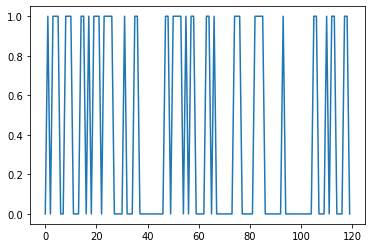

In [45]:
plt.plot(X_train[0])
plt.show()

In [46]:
X_train, y_train = shuffle(X_train,y_train,random_state=60)

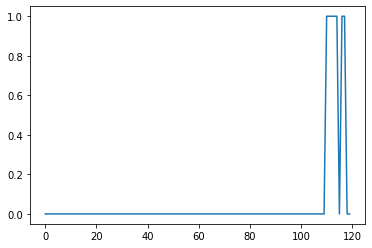

In [47]:
plt.plot(X_train[0])
plt.show()

# Fill Input with noise

In [48]:
def fill_input_with_noise(training_X):
    training_X = np.random.rand(training_X.shape[0],training_X.shape[1],training_X.shape[2])
    return training_X

In [49]:
#X_train = fill_input_with_noise(X_train)

# Defining model

In [50]:
reduce_lr = ReduceLROnPlateau( monitor='val_loss', factor=0.05, patience=5 )

In [51]:
def create_LSTM_model(time_step, n_features):
    tf.keras.backend.clear_session()
    model = Sequential()
    model = Sequential()
    model.add(GRU(256, activation='tanh', input_shape=(time_step, n_features)))
    model.add(Dropout(0.2))
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=Adam(learning_rate=1e-4), metrics=[tf.keras.metrics.AUC(),'accuracy'])
    return model

In [52]:
model = create_LSTM_model(time_step, n_features)

2022-03-05 21:50:59.898054: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-05 21:50:59.898852: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-03-05 21:50:59.927048: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-05 21:50:59.927223: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1050 computeCapability: 6.1
coreClock: 1.493GHz coreCount: 5 deviceMemorySize: 3.95GiB deviceMemoryBandwidth: 104.43GiB/s
2022-03-05 21:50:59.927255: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-03-05 21:50:59.928933: I tensorflow/stream_executor/platform/def

In [53]:
def create_MLP_model(X_train):
    tf.keras.backend.clear_session()
    model = Sequential()
    model.add(Dense(1024,activation='relu',input_shape = (X_train.shape[1],)))
    model.add(Dense(1024,activation='relu'))
    model.add(Dense(1024,activation='relu'))
    model.add(Dense(3,activation='softmax'))
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy',tf.keras.metrics.AUC()])
    return model

In [54]:
# model = create_MLP_model()

In [55]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 256)               198912    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 231,937
Trainable params: 231,937
Non-trainable params: 0
_________________________________________________________________


In [56]:
model.fit(X_train, y_train, epochs =35 , validation_data = (X_val,y_val) ,batch_size = 8, callbacks=[reduce_lr])

Epoch 1/35


2022-03-05 21:51:00.635212: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-03-05 21:51:00.635721: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2799925000 Hz
2022-03-05 21:51:01.889513: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-03-05 21:51:02.080569: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-03-05 21:51:02.103448: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


  14/1705 [..............................] - ETA: 14s - loss: 0.6919 - auc: 0.3718 - accuracy: 0.7271   

Could not load symbol cublasGetSmCountTarget from libcublas.so.11. Error: /usr/local/cuda-11.0/lib64/libcublas.so.11: undefined symbol: cublasGetSmCountTarget


1705/1705 [==============================] - 18s 9ms/step - loss: 0.5387 - auc: 0.6778 - accuracy: 0.7535 - val_loss: 0.4907 - val_auc: 0.6706 - val_accuracy: 0.7858
Epoch 2/35
1705/1705 [==============================] - 15s 9ms/step - loss: 0.4943 - auc: 0.7507 - accuracy: 0.7637 - val_loss: 0.4996 - val_auc: 0.6731 - val_accuracy: 0.7899
Epoch 3/35
1705/1705 [==============================] - 15s 9ms/step - loss: 0.4822 - auc: 0.7690 - accuracy: 0.7731 - val_loss: 0.4981 - val_auc: 0.6683 - val_accuracy: 0.7823
Epoch 4/35
1705/1705 [==============================] - 15s 9ms/step - loss: 0.4801 - auc: 0.7755 - accuracy: 0.7703 - val_loss: 0.4886 - val_auc: 0.6725 - val_accuracy: 0.7902
Epoch 5/35
1705/1705 [==============================] - 15s 9ms/step - loss: 0.4785 - auc: 0.7693 - accuracy: 0.7748 - val_loss: 0.4918 - val_auc: 0.6718 - val_accuracy: 0.7888
Epoch 6/35
1705/1705 [==============================] - 15s 9ms/step - loss: 0.4777 - auc: 0.7702 - accuracy: 0.7761 - val_los

# Train

In [57]:
y_train_predicted = model.predict_proba(X_train)[:,0]

/home/muhammed/Documents/Trading-Bot/TRADING_ENV/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


In [58]:
def plot_prediction_and_auc(predictions,true_values):
    plt.hist(predictions,bins=50, label = "Class 0")
    plt.legend()
    plt.show()
    
    print("AUC = {}".format(roc_auc_score(true_values,predictions)))
    
    fpr, tpr, _ = roc_curve(true_values,  predictions)
    auc = roc_auc_score(true_values, predictions)
    plt.plot(fpr,tpr,label="train, auc="+str(auc))
    plt.plot([0,1],[0,1])
    plt.legend(loc=4)
    plt.show()

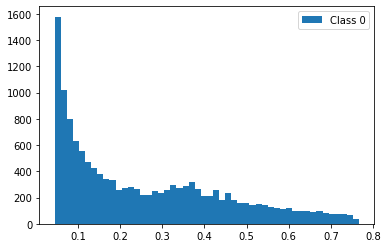

AUC = 0.7747822983116555


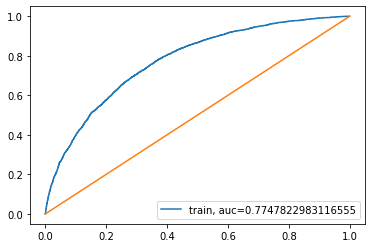

In [59]:
plot_prediction_and_auc(y_train_predicted,y_train)

# Val

In [60]:
y_val_predicted = model.predict_proba(X_val)[:,0]

/home/muhammed/Documents/Trading-Bot/TRADING_ENV/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


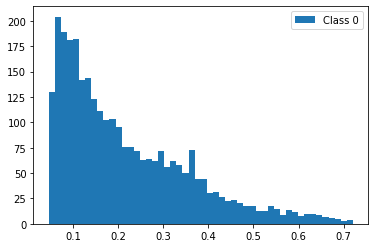

AUC = 0.6774770150682649


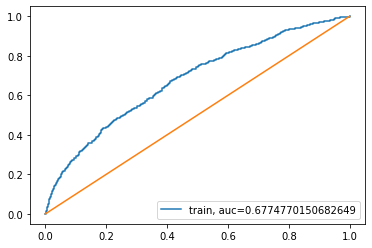

In [61]:
plot_prediction_and_auc(y_val_predicted,y_val)

In [62]:
def plot_precision_recall_f1(preds,truth):
    f1_list = []
    precision_list = []
    recall_list = []
    for i in np.arange(0.01,1.0,0.01):
        preds_converted = (preds >= i)*1
        
        f1_list.append( f1_score(truth,preds_converted) )
        precision_list.append( precision_score(truth,preds_converted,zero_division=0) )
        recall_list.append( recall_score(truth,preds_converted) )
    
    stats_data = pd.concat( [pd.Series(f1_list,name='f1'),pd.Series(precision_list,name='precision'),pd.Series(recall_list,name='recall')] , axis=1 )
    stats_data.index = np.arange(0.01,1.0,0.01)
    
    plt.plot(stats_data['f1'],label='f1')
    plt.plot(stats_data['precision'],label='precision')
    plt.plot(stats_data['recall'],label='recall')
    plt.xlabel('threshold')
    plt.ylabel('score')
    plt.legend()
    plt.show()

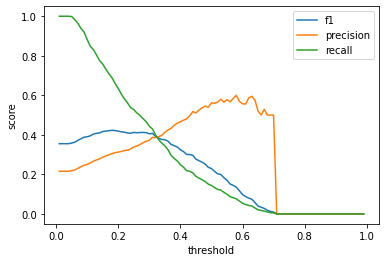

In [63]:
plot_precision_recall_f1(y_val_predicted,y_val)

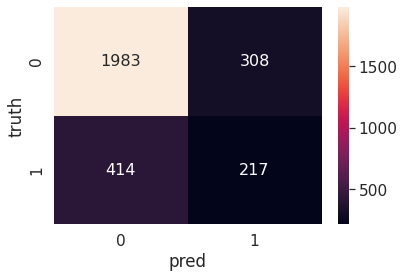

In [64]:
y_val_predicted_class = (y_val_predicted > 0.35) * 1

val_cm = confusion_matrix(y_val,y_val_predicted_class)

df_cm = pd.DataFrame(val_cm, range(2), range(2))
# plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt='g') # font size
plt.xlabel('pred')
plt.ylabel('truth')
plt.show()

# Test

In [65]:
y_test_predicted = model.predict_proba(X_test)

/home/muhammed/Documents/Trading-Bot/TRADING_ENV/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


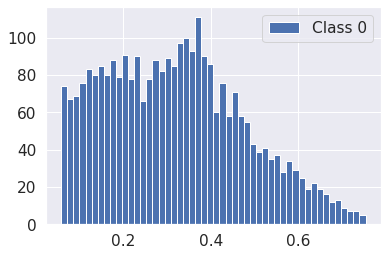

AUC = 0.6527140275954443


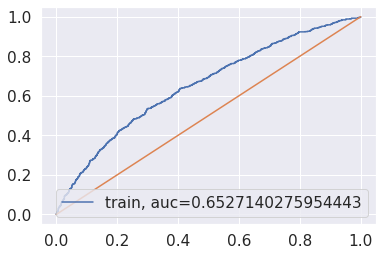

In [66]:
plot_prediction_and_auc(y_test_predicted[:,0],y_test)

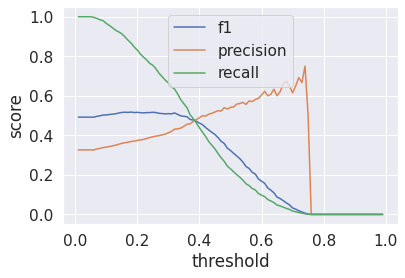

In [67]:
plot_precision_recall_f1(y_test_predicted,y_test)

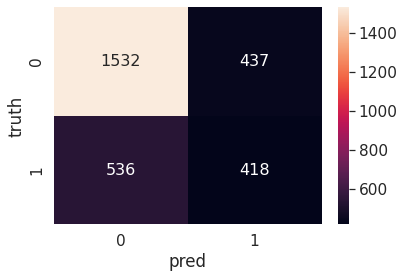

In [68]:
y_test_predicted_class = (y_test_predicted > 0.40) * 1

val_test = confusion_matrix(y_test,y_test_predicted_class)

df_cm = pd.DataFrame(val_test, range(2), range(2))
# plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt='g') # font size
plt.xlabel('pred')
plt.ylabel('truth')
plt.show()

In [69]:
data.shape[0] == X_train.shape[0] + X_val.shape[0] + X_test.shape[0]

True